In [1]:
import os
import importlib.util

# Define the path to config.py
config_path = os.path.abspath(os.path.join(os.path.dirname(r'C:\Users\nilay\OneDrive - Cal State Fullerton (1)\Desktop\NILAY-TO-JOB-DATA\SPRING 2024\CPSC 597 Project\Stock-Price-Prediction'), 'Stock-Price-Prediction', 'config.py'))

# Load the module from the specified path
spec = importlib.util.spec_from_file_location("config", config_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

In [2]:
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

file_path = os.path.join(config.BASE_DIR, 'dataset', 'preprocessed_data', 'INTC.csv')
df = pd.read_csv(file_path)
df = df[['Date', 'Open', 'High', 'Low', 'Close']]

# Convert date from string to datetime
import datetime

def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].apply(str_to_datetime)
df.index = df.pop('Date')
df.dropna(axis=0, inplace=True)

# Initialize scalers for each column
scalers = {
    'Open': MinMaxScaler(),
    'High': MinMaxScaler(),
    'Low': MinMaxScaler(),
    'Close': MinMaxScaler()
}

# Scale each column separately
for column in ['Open', 'High', 'Low', 'Close']:
    df[column] = scalers[column].fit_transform(df[[column]])


c:\Users\nilay\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#### **TRAIN FROM [1990-01-02 - 1998-10-16]**

In [20]:
import pandas as pd
import numpy as np
import datetime

# Redefine str_to_datetime function to handle different date formats if needed
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

# Function to create a windowed dataframe
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X_open, X_high, X_low, X_close, Y_open, Y_high, Y_low, Y_close = [], [], [], [], [], [], [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        open_values = df_subset['Open'].to_numpy()
        high_values = df_subset['High'].to_numpy()
        low_values = df_subset['Low'].to_numpy()
        close_values = df_subset['Close'].to_numpy()

        X_open.append(open_values[:-1])
        Y_open.append(open_values[-1])
        
        X_high.append(high_values[:-1])
        Y_high.append(high_values[-1])
        
        X_low.append(low_values[:-1])
        Y_low.append(low_values[-1])
        
        X_close.append(close_values[:-1])
        Y_close.append(close_values[-1])

        dates.append(target_date)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year, month, day = map(int, next_date_str.split('-'))
        next_date = datetime.datetime(year=year, month=month, day=day)

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    data = {
        'Target Date': dates
    }

    X_open = np.array(X_open)
    X_high = np.array(X_high)
    X_low = np.array(X_low)
    X_close = np.array(X_close)

    for i in range(n):
        data[f'Open-{n-i}'] = X_open[:, i]
        data[f'High-{n-i}'] = X_high[:, i]
        data[f'Low-{n-i}'] = X_low[:, i]
        data[f'Close-{n-i}'] = X_close[:, i]

    data['Open-Target'] = Y_open
    data['High-Target'] = Y_high
    data['Low-Target'] = Y_low
    data['Close-Target'] = Y_close

    ret_df = pd.concat({key: pd.Series(value) for key, value in data.items()}, axis=1)

    return ret_df

# Start day second time around: 1990-01-02 -- 2006-12-29
windowed_df = df_to_windowed_df(df, 
                                '1990-01-02', 
                                '2000-12-29',
                                n=5)
windowed_df


,Target Date,Open-5,High-5,Low-5,Close-5,Open-4,High-4,Low-4,Close-4,Open-3,...,Low-2,Close-2,Open-1,High-1,Low-1,Close-1,Open-Target,High-Target,Low-Target,Close-Target
0,1990-01-02,0.010879,0.011159,0.011210,0.011022,0.010879,0.010953,0.010891,0.010761,0.010879,...,0.011423,0.011336,0.011293,0.011418,0.011529,0.011546,0.011397,0.011986,0.011529,0.012173
1,1990-01-03,0.010879,0.010953,0.010891,0.010761,0.010879,0.011263,0.011104,0.011336,0.011189,...,0.011529,0.011546,0.011397,0.011986,0.011529,0.012173,0.012018,0.012089,0.011955,0.011755
2,1990-01-04,0.010879,0.011263,0.011104,0.011336,0.011189,0.011263,0.011423,0.011336,0.011293,...,0.011529,0.012173,0.012018,0.012089,0.011955,0.011755,0.011707,0.011986,0.011742,0.012069
3,1990-01-05,0.011189,0.011263,0.011423,0.011336,0.011293,0.011418,0.011529,0.011546,0.011397,...,0.011955,0.011755,0.011707,0.011986,0.011742,0.012069,0.011915,0.011986,0.012061,0.011964
4,1990-01-08,0.011293,0.011418,0.011529,0.011546,0.011397,0.011986,0.011529,0.012173,0.012018,...,0.011742,0.012069,0.011915,0.011986,0.012061,0.011964,0.011915,0.012089,0.012168,0.012173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2775,2000-12-22,0.455450,0.456706,0.437227,0.431581,0.450477,0.453399,0.438717,0.442464,0.444675,...,0.426159,0.424884,0.421467,0.452779,0.427862,0.440790,0.443017,0.460012,0.432970,0.438278
2776,2000-12-26,0.450477,0.453399,0.438717,0.442464,0.444675,0.476545,0.450850,0.444975,0.433900,...,0.427862,0.440790,0.443017,0.460012,0.432970,0.438278,0.436386,0.445133,0.432970,0.437441
2777,2000-12-27,0.444675,0.476545,0.450850,0.444975,0.433900,0.448440,0.426159,0.424884,0.421467,...,0.432970,0.438278,0.436386,0.445133,0.432970,0.437441,0.430584,0.442653,0.437227,0.433255
2778,2000-12-28,0.433900,0.448440,0.426159,0.424884,0.421467,0.452779,0.427862,0.440790,0.443017,...,0.432970,0.437441,0.430584,0.442653,0.437227,0.433255,0.423125,0.429428,0.406577,0.411490


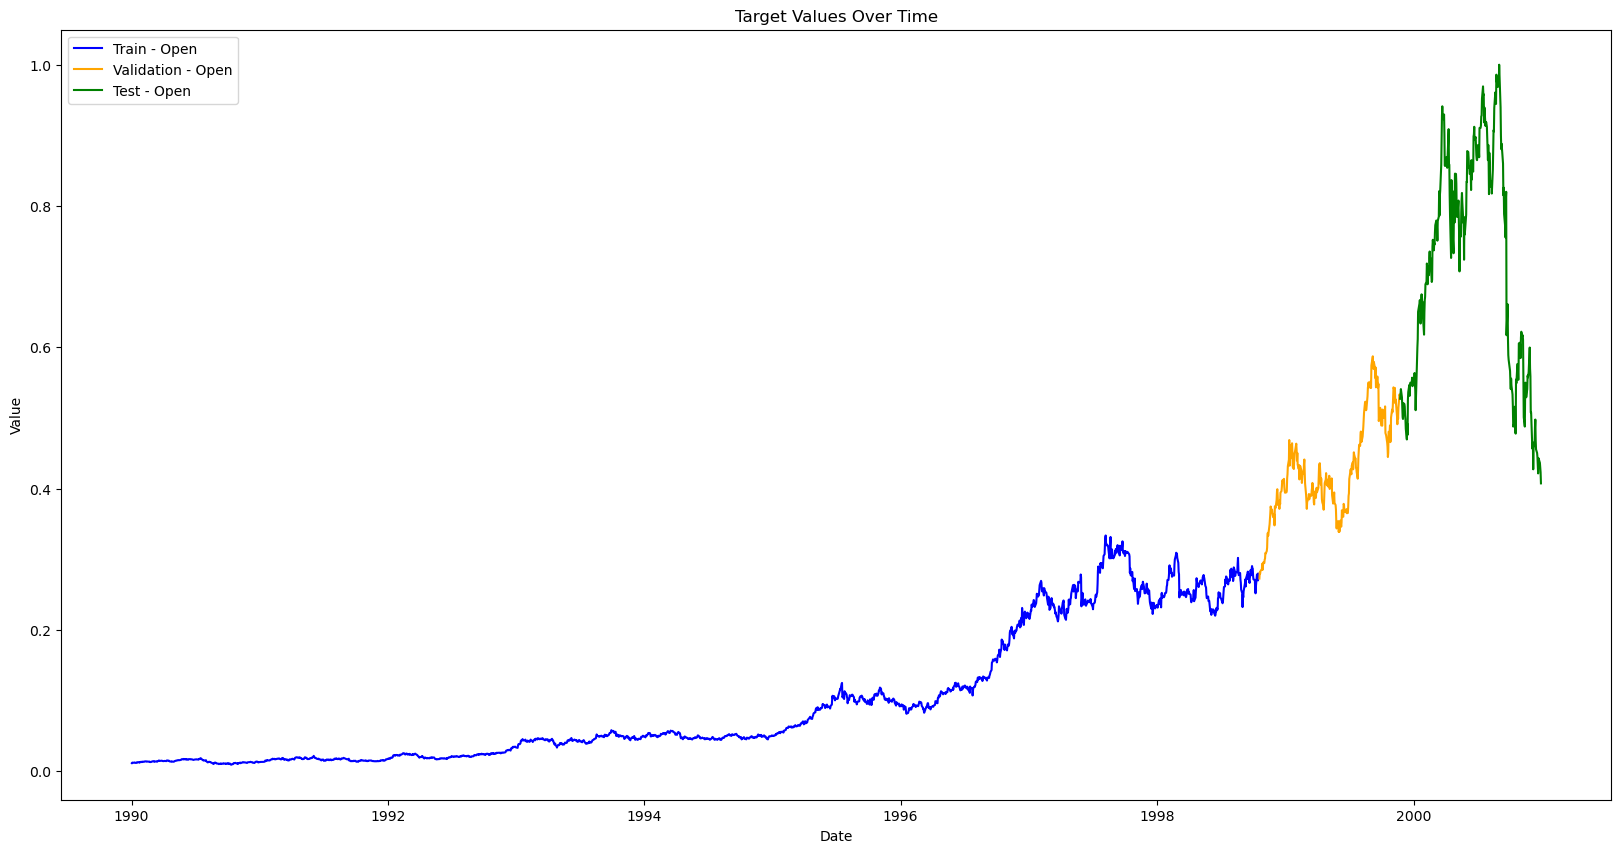

In [21]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    # Extract the features (Open, High, Low, Close) from the columns
    middle_matrix = df_as_np[:, 1:-4]
    # Reshape the features matrix to include the multiple feature sets
    # Each row has n Open, High, Low, and Close values
    num_features = 4  # We have Open, High, Low, Close
    n = (middle_matrix.shape[1] // num_features)  # Number of time steps (n=3 in this case)
    X = middle_matrix.reshape((len(dates), n, num_features))

    # Extract the target values (Open-Target, High-Target, Low-Target, Close-Target)
    Y_open = df_as_np[:, -4]
    Y_high = df_as_np[:, -3]
    Y_low = df_as_np[:, -2]
    Y_close = df_as_np[:, -1]

    # Combine all target values into a single array
    Y = np.stack((Y_open, Y_high, Y_low, Y_close), axis=-1)

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

import matplotlib.pyplot as plt

q_80 = int(len(dates) * .80)
q_90 = int(len(dates) * .90)

dates_train2, X_train2, y_train2 = dates[:q_80], X[:q_80], y[:q_80]
dates_val2, X_val2, y_val2 = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test2, X_test2, y_test2 = dates[q_90:], X[q_90:], y[q_90:]

plt.figure(figsize=(20, 10))

# Plotting target values for each feature set
plt.plot(dates_train2, y_train2[:, 0], label='Train - Open', color='blue')
plt.plot(dates_val2, y_val2[:, 0], label='Validation - Open', color='orange')
plt.plot(dates_test2, y_test2[:, 0], label='Test - Open', color='green')

plt.legend()
plt.title('Target Values Over Time')
plt.xlabel('Date')
plt.ylabel('Value')

plt.show()

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model_2 = Sequential([
    layers.Input((3, 4)),
    layers.LSTM(256),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(4)
])

# Compile the model
model_2.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True)

# Train the model with early stopping
model_2.fit(X_train2, y_train2, 
          validation_data=(X_val2, y_val2), 
          epochs=100, 
          callbacks=[early_stopping])


Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0039 - mean_absolute_error: 0.0346 - val_loss: 3.5365e-04 - val_mean_absolute_error: 0.0149
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.9985e-05 - mean_absolute_error: 0.0034 - val_loss: 3.1538e-04 - val_mean_absolute_error: 0.0143
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3.0779e-05 - mean_absolute_error: 0.0033 - val_loss: 3.4809e-04 - val_mean_absolute_error: 0.0150
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.3232e-05 - mean_absolute_error: 0.0033 - val_loss: 4.2973e-04 - val_mean_absolute_error: 0.0170
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.9119e-05 - mean_absolute_error: 0.0033 - val_loss: 4.8307e-04 - val_mean_absolute_error: 0.0170
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.1864e-05 - mean_absolute_error: 0.0041 - val_loss: 3.1970e-04 - val_mean_absolute_error: 0.0139
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - lo

##### **TEST FROM [1999-11-24  -- 2000-12-29]**

In [23]:
# Make predictions on the test data
predictions = model_2.predict(X_test2)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


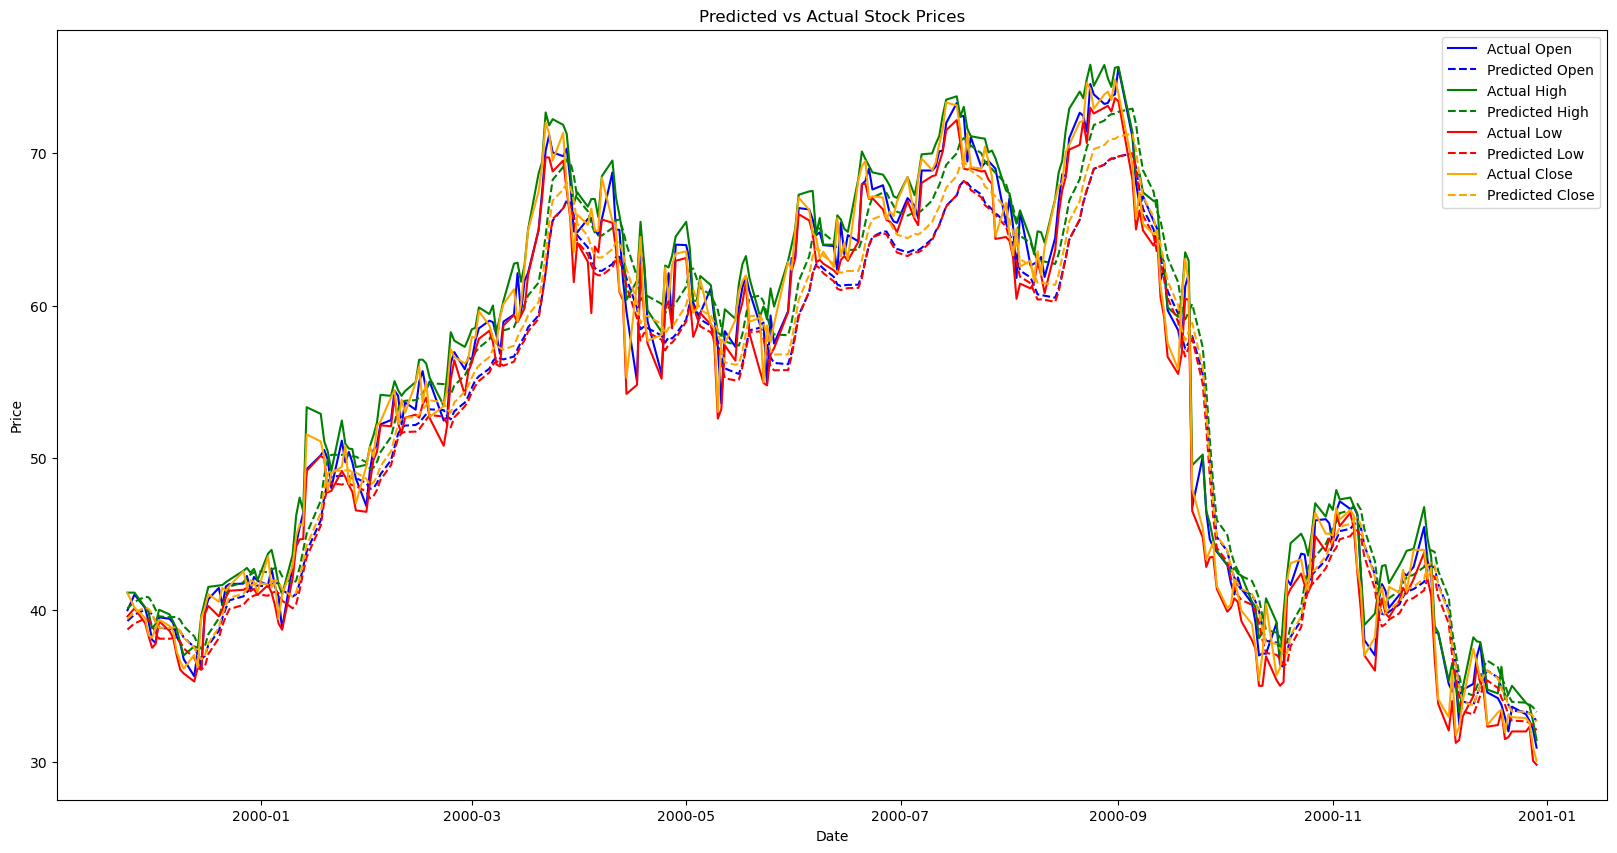

In [24]:
# Make predictions on the test data
predictions = model_2.predict(X_test2)

# Inverse transform the predicted and actual values
def inverse_transform(scaler, data):
    data = data.reshape(-1, 1)
    return scaler.inverse_transform(data).reshape(-1)

predicted_open = inverse_transform(scalers['Open'], predictions[:, 0])
predicted_high = inverse_transform(scalers['High'], predictions[:, 1])
predicted_low = inverse_transform(scalers['Low'], predictions[:, 2])
predicted_close = inverse_transform(scalers['Close'], predictions[:, 3])

actual_open = inverse_transform(scalers['Open'], y_test2[:, 0])
actual_high = inverse_transform(scalers['High'], y_test2[:, 1])
actual_low = inverse_transform(scalers['Low'], y_test2[:, 2])
actual_close = inverse_transform(scalers['Close'], y_test2[:, 3])

# Plotting the predicted vs. actual values
plt.figure(figsize=(20, 10))

plt.plot(dates_test2, actual_open, label='Actual Open', color='blue')
plt.plot(dates_test2, predicted_open, label='Predicted Open', color='blue', linestyle='dashed')

plt.plot(dates_test2, actual_high, label='Actual High', color='green')
plt.plot(dates_test2, predicted_high, label='Predicted High', color='green', linestyle='dashed')

plt.plot(dates_test2, actual_low, label='Actual Low', color='red')
plt.plot(dates_test2, predicted_low, label='Predicted Low', color='red', linestyle='dashed')

plt.plot(dates_test2, actual_close, label='Actual Close', color='orange')
plt.plot(dates_test2, predicted_close, label='Predicted Close', color='orange', linestyle='dashed')

plt.legend()
plt.title('Predicted vs Actual Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [25]:
dates_train2

array([Timestamp('1990-01-02 00:00:00'), Timestamp('1990-01-03 00:00:00'),
       Timestamp('1990-01-04 00:00:00'), ...,
       Timestamp('1998-10-14 00:00:00'), Timestamp('1998-10-15 00:00:00'),
       Timestamp('1998-10-16 00:00:00')], dtype=object)

##### **TEST DATA [1999-11-24 -- 2000-12-29]**

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


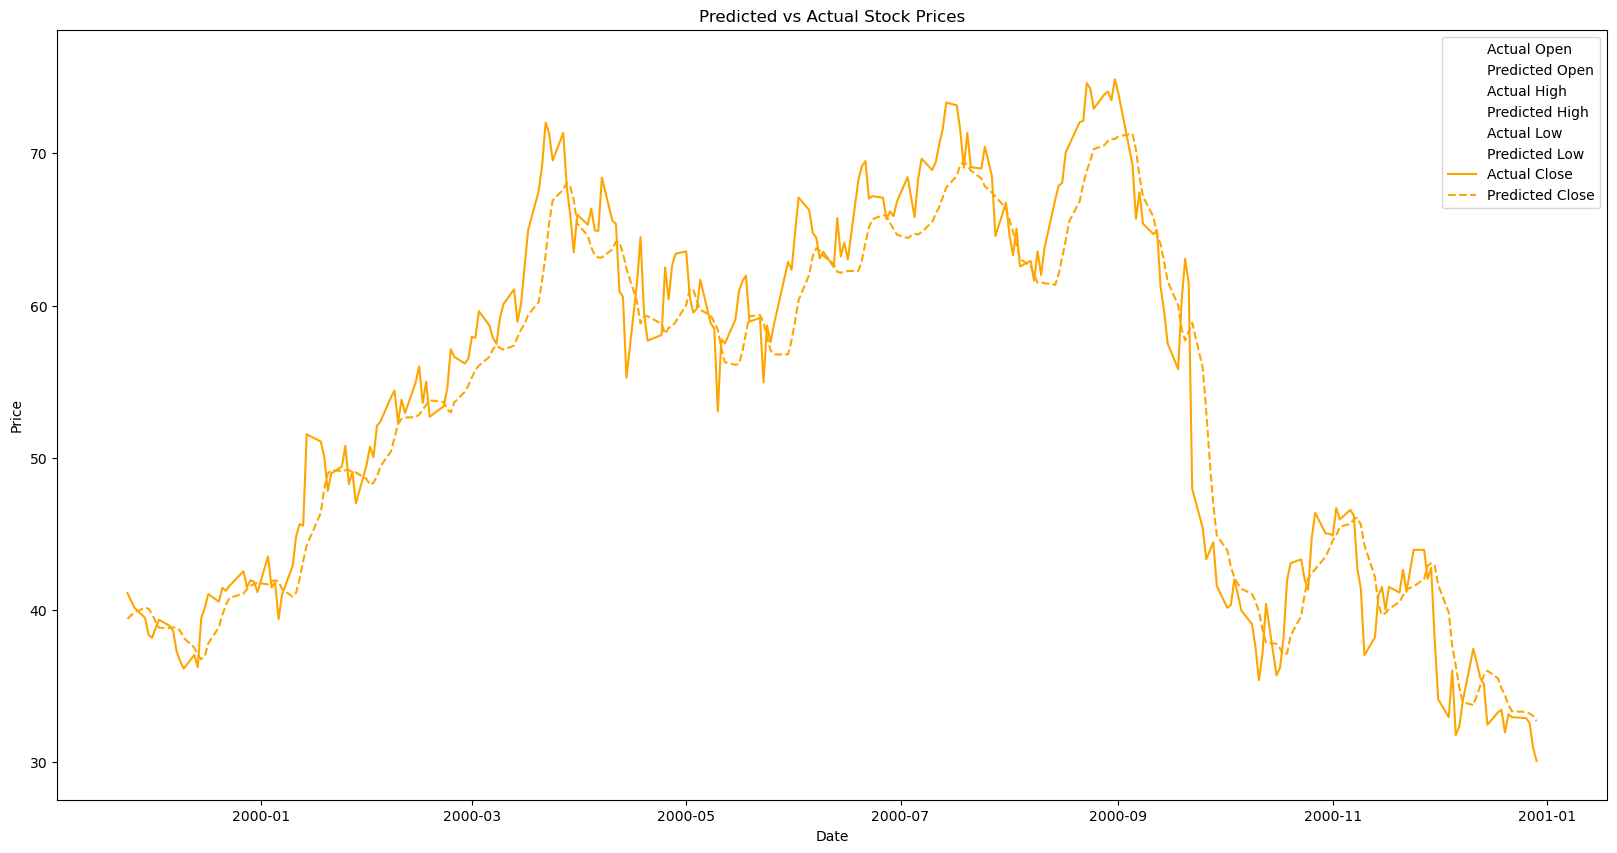

In [26]:
# Make predictions on the test data
predictions = model_2.predict(X_test2)

# Inverse transform the predicted and actual values
def inverse_transform(scaler, data):
    data = data.reshape(-1, 1)
    return scaler.inverse_transform(data).reshape(-1)

predicted_open = inverse_transform(scalers['Open'], predictions[:, 0])
predicted_high = inverse_transform(scalers['High'], predictions[:, 1])
predicted_low = inverse_transform(scalers['Low'], predictions[:, 2])
predicted_close = inverse_transform(scalers['Close'], predictions[:, 3])

actual_open = inverse_transform(scalers['Open'], y_test2[:, 0])
actual_high = inverse_transform(scalers['High'], y_test2[:, 1])
actual_low = inverse_transform(scalers['Low'], y_test2[:, 2])
actual_close = inverse_transform(scalers['Close'], y_test2[:, 3])

# Plotting the predicted vs. actual values
plt.figure(figsize=(20, 10))

plt.plot(dates_test2, actual_open, label='Actual Open', color='white')
plt.plot(dates_test2, predicted_open, label='Predicted Open', color='white', linestyle='dashed')

plt.plot(dates_test2, actual_high, label='Actual High', color='white')
plt.plot(dates_test2, predicted_high, label='Predicted High', color='white', linestyle='dashed')

plt.plot(dates_test2, actual_low, label='Actual Low', color='white')
plt.plot(dates_test2, predicted_low, label='Predicted Low', color='white', linestyle='dashed')

plt.plot(dates_test2, actual_close, label='Actual Close', color='orange')
plt.plot(dates_test2, predicted_close, label='Predicted Close', color='orange', linestyle='dashed')

plt.legend()
plt.title('Predicted vs Actual Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()